In [36]:
"""
Comprehensive Random Forest analysis using real feature names
This script loads RF results, maps feature indices to real names, extracts metrics,
and produces various plots with readable feature labels.
"""
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    auc
)

| Chiave                 | Contiene…                        | Perché è utile?                    |
| ---------------------- | -------------------------------- | ---------------------------------- |
| `model_name`           | Nome modello                     | Per sapere che algoritmo hai usato |
| `cv_fold_scores`       | Score per ogni fold              | Stabilità delle performance        |
| `cv_fold_importances`  | Importanza feature per fold      | Coerenza delle feature importanti  |
| `cv_fold_predictions`  | Predizioni per fold              | Calcolo metriche                   |
| `cv_fold_estimators`   | I modelli per ogni fold          | Esaminare e usare singoli modelli  |
| `selected_features`    | Feature selezionate              | Quali feature sono state usate     |
| `feature_frequency`    | Quante volte una feature è usata | Robustezza delle feature           |
| `feature_importances`  | Importanza media feature         | Ranking delle feature              |
| `weighted_importances` | Importanze pesate per fold       | Valutazione più precisa            |
| `outer_cv`             | Dati cross-val esterna           | Per nested CV                      |
| `best_fold`            | Il fold migliore                 | Analisi dettagliata                |
| `predictions`          | Predizioni finali                | Calcolo metriche totali            |
| `metric_scores`        | Score finali (es. accuracy)      | Valutazione globale del modello    |


In [52]:
# 1.Load RF results from the pickle file

file_path = '/Users/Altair93/Documents/Dottorato/PATHS/Python_analisys/Results/ML/data/univariate/univ_exponent_delta_barthel_singleoutput_baseline_rs42.pkl'
with open(file_path, 'rb') as f:
    results = pickle.load(f)['Random Forest']

# --- Configuration for saving figures ---
output_dir = '/Users/Altair93/Documents/Dottorato/PATHS/Python_analisys/Results/ML/figures'
os.makedirs(output_dir, exist_ok=True)
# --- End of configuration ---

# 2. Define covariates and spatial features
covariates = ["age", "sex", "education", "stroke_aetiology", "time_onset_eeg"]
spatial_units = ["FL", "FR", "CL", "CR", "TR", "TL", "PR", "PL", "OL", "OR"]
feature_names_base = ["exponent"]  # "offset" "exponent", "lziv", "higuci", "theta", "delta

# Build full list of feature names in order
all_features = covariates + [f"{fn}_{sp}" for fn in feature_names_base for sp in spatial_units]
# Map 'feature_i' -> real name
idx_to_name = {f"feature_{i}": name for i, name in enumerate(all_features)}

In [53]:
results.keys()

dict_keys(['cv_fold_scores', 'cv_fold_importances', 'cv_fold_predictions', 'cv_fold_estimators', 'model_name', 'params', 'predictions', 'metric_scores'])

In [59]:
#print values inside cv_fold_scores
results["cv_fold_scores"]

{'r2': array([-0.56479973,  0.52502403, -3.29713143, -1.34220417,  0.05911289])}

In [55]:
# print the values inside metric_scores
results["metric_scores"]
results["predictions"]

'predictions'

In [41]:
# print type of each key in the results dictionary
for key in results.keys():
    print(type("key"), key, type(results[key]))




<class 'str'> cv_fold_scores <class 'dict'>
<class 'str'> cv_fold_importances <class 'dict'>
<class 'str'> cv_fold_predictions <class 'list'>
<class 'str'> cv_fold_estimators <class 'list'>
<class 'str'> model_name <class 'str'>
<class 'str'> params <class 'dict'>
<class 'str'> predictions <class 'str'>
<class 'str'> metric_scores <class 'str'>


In [56]:
# 3. Model performance
fold_scores = results['cv_fold_scores']
# If fold_scores is a dict, extract the first metric (e.g., 'r2')
if isinstance(fold_scores, dict):
    metric_name, scores = next(iter(fold_scores.items()))
    print(f"Cross-validation fold scores ({metric_name}):", scores)
    print(f"Mean ± std: {np.mean(scores):.3f} ± {np.std(scores):.3f}")
else:
    print("Cross-validation fold scores:", fold_scores)
    print(f"Mean ± std: {np.mean(fold_scores):.3f} ± {np.std(fold_scores):.3f}")
print("Overall metric scores:", results['metric_scores'], "\n")

# 4. Feature importances (mean across folds)
cv_fold_imp = results['cv_fold_importances']  # dict: 'feature_i' -> array of importances per fold
# Compute mean and std for each feature
feat_imp = {k: {'mean': np.mean(v), 'std': np.std(v)} for k, v in cv_fold_imp.items()}
# Map indices to names
named_imp = {idx_to_name[k]: v for k, v in feat_imp.items()}
# Sort descending by mean importance
sorted_imp = dict(sorted(named_imp.items(), key=lambda x: x[1]['mean'], reverse=True))
# Print top 10
print("Top features by importance:")
for name, imp in list(sorted_imp.items())[:10]:
    print(f"{name}: {imp['mean']:.3f}")

Cross-validation fold scores (r2): [-0.56479973  0.52502403 -3.29713143 -1.34220417  0.05911289]
Mean ± std: -0.924 ± 1.342
Overall metric scores: metrics 

Top features by importance:
exponent_FR: 0.173
time_onset_eeg: 0.153
exponent_CR: 0.105
education: 0.102
exponent_TR: 0.102
exponent_CL: 0.078
age: 0.077
exponent_FL: 0.076
stroke_aetiology: 0.072
sex: 0.062


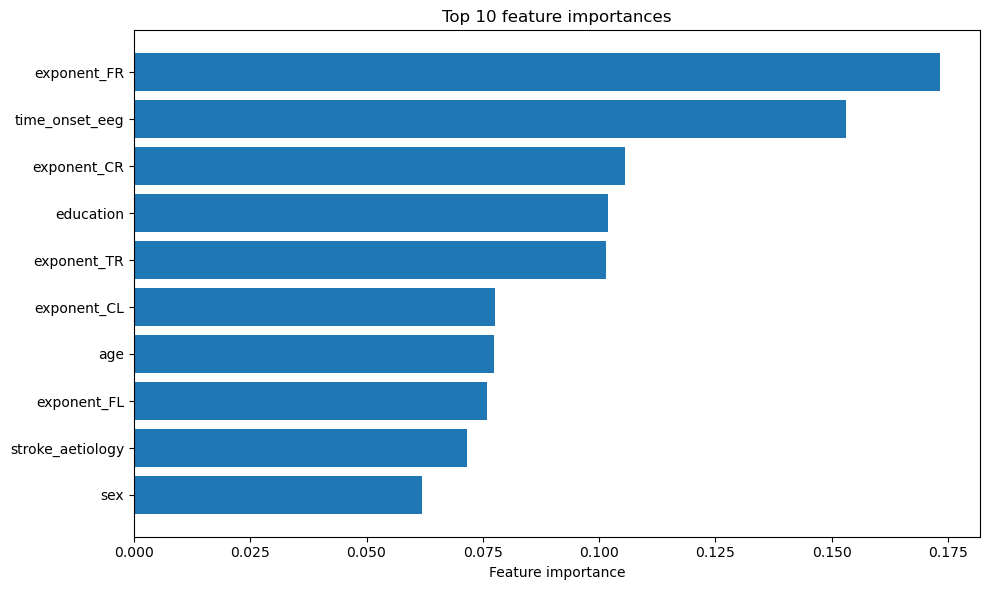

Saved figure to /Users/Altair93/Documents/Dottorato/PATHS/Python_analisys/Results/ML/figures/DeltaBarthel_feature_importance.png


In [57]:
top_k = 10
top_feats = list(sorted_imp.keys())[:top_k]
top_vals = list(sorted_imp.values())[:top_k]
fig = plt.figure(figsize=(10, 6))
plt.barh(top_feats[::-1], [v['mean'] for v in top_vals[::-1]])
plt.xlabel('Feature importance')
plt.title(f'Top {top_k} feature importances')
plt.tight_layout()
fig_path = os.path.join(output_dir, 'DeltaBarthel_feature_importance.png')
fig.savefig(fig_path)
plt.show()
print(f"Saved figure to {fig_path}")

In [29]:
# 5. Feature frequency histogram
if 'feature_frequency' in results:
	freq = results['feature_frequency']
	named_freq = {idx_to_name.get(k, k): v for k, v in freq.items()}
	fig = plt.figure(figsize=(12, 6))
	plt.bar(named_freq.keys(), named_freq.values())
	plt.xlabel('Feature')
	plt.ylabel('Frequency across folds')
	plt.title('Feature selection frequency')
	plt.xticks(rotation=90)
	plt.tight_layout()
	fig.savefig(os.path.join(output_dir, 'DeltaBarthel_feature_frequency.png'))
	plt.close(fig)

	# 6. Aggregate by feature type
	fig = plt.figure(figsize=(8, 5))
	type_freq = {t: sum(v for k, v in freq.items() if idx_to_name.get(k, '').startswith(t + '_')) for t in feature_names_base}
	plt.bar(type_freq.keys(), type_freq.values())
	plt.xlabel('Feature type')
	plt.ylabel('Total frequency')
	plt.title('Feature frequency by type')
	plt.tight_layout()
	fig.savefig(os.path.join(output_dir, 'DeltaBarthel_feature_frequency_by_type.png'))
	plt.close(fig)
else:
	print("Key 'feature_frequency' not found in results. Available keys:", list(results.keys()))



Key 'feature_frequency' not found in results. Available keys: ['cv_fold_scores', 'cv_fold_importances', 'cv_fold_predictions', 'cv_fold_estimators', 'model_name', 'params', 'predictions', 'metric_scores']


/var/folders/w2/8rzmmn057sn7_j0jxhr532cw0000gn/T/ipykernel_57518/3872674194.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(list(named_cv.values()), labels=list(named_cv.keys()), vert=False)


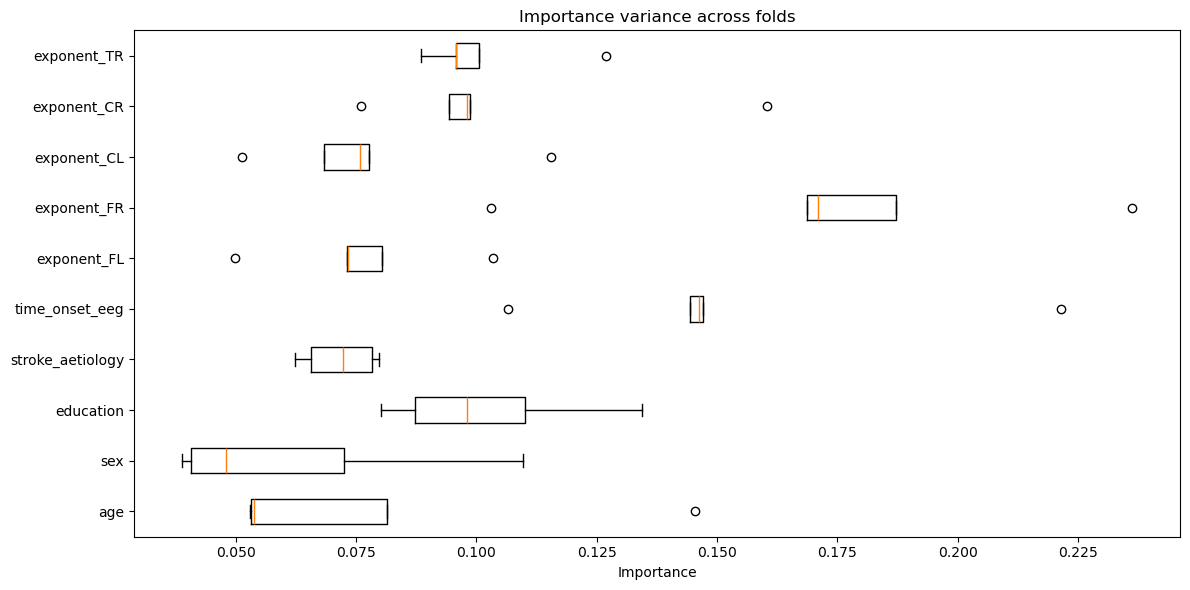

In [58]:
# 8. Variance of importances across folds
cv_imps = results['cv_fold_importances']
named_cv = {idx_to_name[k]: v for k, v in cv_imps.items()}
fig = plt.figure(figsize=(12, 6))
plt.boxplot(list(named_cv.values()), labels=list(named_cv.keys()), vert=False)
plt.xlabel('Importance')
plt.title('Importance variance across folds')
plt.tight_layout()
fig.savefig(os.path.join(output_dir, 'DeltaBarthel_importance_variance_boxplot.png'))
plt.show()
plt.close(fig)


In [20]:
# 8. Best fold details with real feature names
best_fold = results['best_fold']
bf_index = best_fold['fold']
bf_feats = [idx_to_name.get(f, f) for f in best_fold['features']]
bf_score = best_fold['score']
print(f"Best fold: {bf_index}, Score: {bf_score}")
print("Features in best fold:", bf_feats)


KeyError: 'best_fold'

In [21]:
# 14. Combined scatter plots for regression predictions
fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4))
axes = axes.flatten()
for i, p in enumerate(cv_preds):
    y_t, y_p = p['y_true'], p['y_pred']
    axes[i].scatter(y_t, y_p)
    minv, maxv = min(y_t), max(y_t)
    axes[i].plot([minv, maxv], [minv, maxv], 'r--')
    axes[i].set_title(f'Fold {i}')
    axes[i].set_xlabel('True')
    axes[i].set_ylabel('Pred')
for ax in axes[n_folds:]: ax.axis('off')
plt.tight_layout()
fig.savefig(os.path.join(output_dir, 'DeltaBarthel_prediction_scatter.png'))
plt.show()
plt.close(fig)
print('Saved combined scatter plots to', os.path.join(output_dir, 'DeltaBarthel_prediction_scatter.png'))


NameError: name 'rows' is not defined

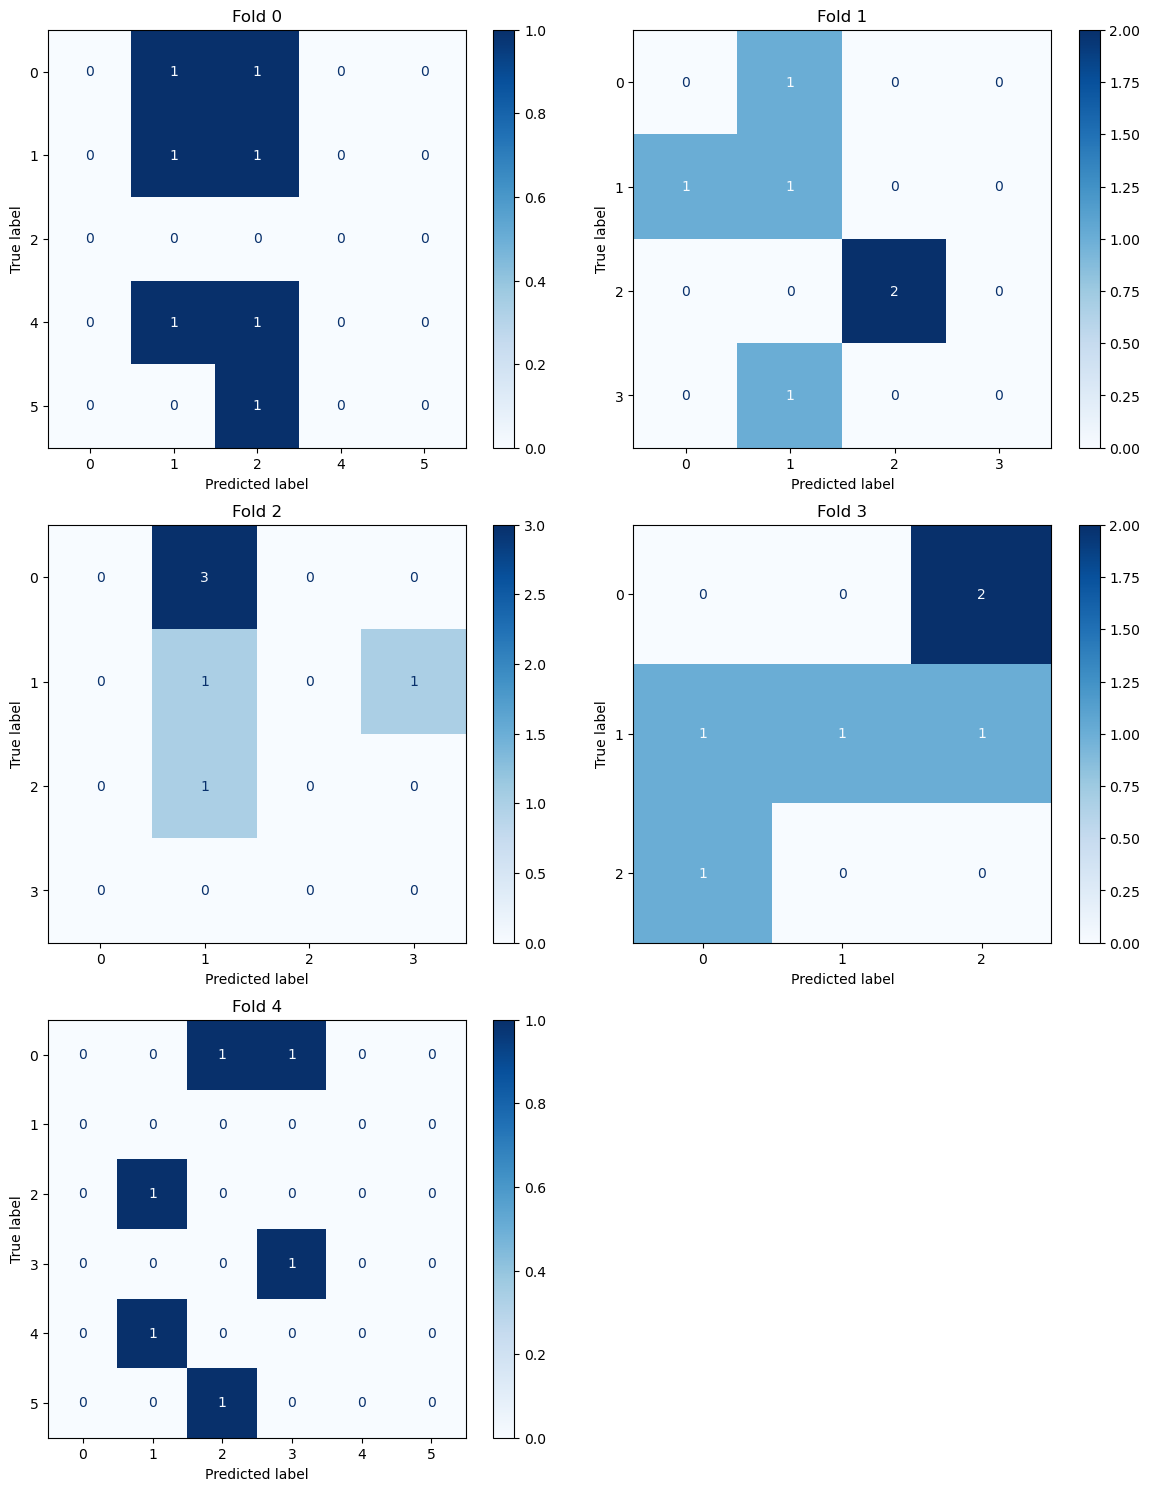

Saved combined confusion matrices to /Users/Altair93/Documents/Dottorato/PATHS/Python_analisys/Results/ML/figures/DeltaBarthel_confusion_matrices.png


In [22]:
# 11. Combined confusion matrices for all folds in one figure (for regression: bin values into classes)
cv_preds = results['cv_fold_predictions']
n_folds = len(cv_preds)
cols = 2
rows = (n_folds + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(cols*6, rows*5))
axes = axes.flatten()

# Define bins for discretization (e.g., 5 bins)
n_bins = 5
all_true = np.concatenate([fold['y_true'] for fold in cv_preds])
bins = np.linspace(all_true.min(), all_true.max(), n_bins + 1)

for i, (fold_idx, preds) in enumerate(enumerate(cv_preds)):
    y_true_f, y_pred_f = preds['y_true'], preds['y_pred']
    y_true_binned = np.digitize(y_true_f, bins) - 1
    y_pred_binned = np.digitize(y_pred_f, bins) - 1
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true_binned, y_pred_binned, ax=axes[i], cmap='Blues', values_format='d'
    )
    disp.ax_.set_title(f'Fold {fold_idx}')
# Hide unused axes
for ax in axes[n_folds:]:
    ax.axis('off')
plt.tight_layout()
combo_path = os.path.join(output_dir, 'DeltaBarthel_confusion_matrices.png')
fig.savefig(combo_path)
plt.show()
plt.close(fig)
print(f"Saved combined confusion matrices to {combo_path}")


In [23]:
#10) Summary of regression metrics per fold
summary = []
for fold_idx, preds in enumerate(cv_preds):
    y_true_f, y_pred_f = preds['y_true'], preds['y_pred']
    summary.append({
        'fold': fold_idx,
        'mse': mean_squared_error(y_true_f, y_pred_f),
        'r2': r2_score(y_true_f, y_pred_f)
    })
df_summary = pd.DataFrame(summary)
print("Summary of regression metrics per fold:")
print(df_summary)

NameError: name 'mean_squared_error' is not defined